In [ ]:
# standard loads
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import h5py
import random

# import the despiking functions from UKDE_despike_ArtificialTurb.py
from UKDE_despike_ArtificialTurb import * 

# %config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

In [2]:
#load h5 but don't plot colormap
icase = 2      # 1=BLdns1 | 2=BLdns2
DIR = '/Users/sam/Dropbox/MS_Research_KrausSam/ADV_DataProcessing/Field_despike_v03/Artificial_Turbulence/Towne2023_UMich_DNS/BLdns2'

# Example plot data from BLdns2_planes.h5
file_planes_dir     = DIR+'/BLdns'+str(icase)+'_planes.h5'
file_parameters_dir = DIR+'/BLdns'+str(icase)+'_parameters.h5'
file_grid_dir       = DIR+'/BLdns'+str(icase)+'_grid.h5'
file_planes         = h5py.File(file_planes_dir,'r')
file_parameters     = h5py.File(file_parameters_dir,'r')
file_grid           = h5py.File(file_grid_dir,'r')

print('file_planes keys: ', file_planes.keys())
print('file_parameters keys: ', file_parameters.keys())
print('file_grid keys: ', file_grid.keys())

file_planes keys:  <KeysViewHDF5 ['Uplane', 'Vplane', 'Wplane']>
file_parameters keys:  <KeysViewHDF5 ['Lo', 'Lx', 'Ly', 'Lz', 'Retau_inlet', 'Retau_outlet', 'Retheta_inlet', 'Retheta_outlet', 'Uinf', 'delta99_inlet', 'delta99_outlet', 'dt', 'dt_plane', 'nu', 'theta_inlet', 'theta_outlet', 'time']>
file_grid keys:  <KeysViewHDF5 ['x', 'y', 'yd', 'z', 'zd']>


In [3]:
Uplane = file_planes['Uplane'][()]

In [4]:
x      = file_grid['x'][()][0]
y      = file_grid['y'][()][0]
time_arr   = file_parameters['time'][()][:,0]
Uinf   = file_parameters['Uinf'][()][0]
Lo     = file_parameters['Lo'][()][0]
tref   = 1000 # arbitrary time = time(tref)

In [5]:
def snapshot_pcolor(tref, x, y, Lo, Uplane, Uinf):
    # streamwise velocity as a function of t and x
    fig, ax = plt.subplots(figsize=(15.,1.5))
    X, Y = np.meshgrid(x/Lo, y/Lo)
    Z = Uplane.T[tref,:,:]/Uinf
    plt.pcolor(X,Y,Z.T, shading='nearest', cmap='bone') # shading 'interp' not in matplotlib # viridis
    plt.xlabel(r'$x/L_o$')
    plt.ylabel(r'$y/L_o$')
    plt.axis('equal')
    plt.axis('tight')
#     plt.xlim([2.5,3.2234287])
#     plt.ylim([0,0.06])
    plt.colorbar(label='$U/U_{\infty}$')
    plt.savefig('/Users/sam/Desktop/Figures_Individual'+'/BoundaryLayer_snapshot.png', 
                dpi=1200, bbox_inches='tight', pad_inches=plotpad)
    plt.show()
    plt.close() 

# tref = 7000
# plotpad = 0.05
# snapshot_pcolor(tref, x, y, Lo, Uplane, Uinf)

In [6]:
def find_nearest(array, value):
    idx = np.abs(array - value).argmin()
    return idx

# x_vals = np.array([2.62,2.7,2.79,2.86,3.06,2.53,2.65,3.1,2.82,3.12])
# y_vals = np.array([0.03,0.02,0.04,0.01,0.016,0.01,0.008,0.02,0.007,0.005])
x_vals = np.array([2.62,2.79,3.06,2.65,2.82])
y_vals = np.array([0.03,0.04,0.016,0.008,0.007])

x_grab = np.zeros(len(x_vals), dtype=int)
y_grab = np.zeros(len(y_vals), dtype=int)

for i_grab in range(len(x_vals)):
    x_grab[i_grab] = find_nearest(x, x_vals[i_grab])
    y_grab[i_grab] = find_nearest(y, y_vals[i_grab])

print('x indices: ', x_grab)
print('y indices: ', y_grab)
print('x coord: ', x[x_grab])
print('y coord: ', y[y_grab])

x indices:  [2984 3297 3795 3040 3353]
y indices:  [118 126 100  80  76]
x coord:  [2.6198761 2.789761  3.060057  2.650271  2.8201556]
y coord:  [0.03021245 0.03986381 0.0161851  0.00807205 0.00701888]


In [22]:
##  --- User input ----------------------------- 
pos = 10 # percentage of spikes added
i_point = 4 # index of pre-determined points

# quick and dirty
x_grab = x_grab
y_grab = y_grab
fs_sample = 1000 # original sample from dataset is 1000, anything below will subsample
fs = fs_sample

dir_working = '/Users/sam/Desktop/Misc./Code/Despike_Misc/UKDE-hybrid_ArtificialSpikes_ptNo'+str(i_point+1)+'_'+str(pos)+'pos'

##  -------------------------------------------


print('fs = ', fs)
skip = int(1000 / fs) # interval at which to sample original timeseries elements, not automated
print('skip = ', skip)
print('x = ', x[x_grab]) # 3.0627708 # len(x) = 4097
print('y = ', y[y_grab]) # 0.016185101 # len(y) = 180, could be up to 130, maybe as low as 35

# define the output folders
velfilter_folder = dir_working+'/Data_Filtered'
fig_folder = dir_working+'/Figures'

# Make the output folders
if os.path.isdir(dir_working) !=1:
    os.mkdir(dir_working)
if os.path.isdir(velfilter_folder) !=1:
    os.mkdir(velfilter_folder)
if os.path.isdir(fig_folder) !=1:
    os.mkdir(fig_folder)


# create artificial spikes --------------------------------------------
perc_randspikes = pos

no_grab_pts = len(x_grab)

# initialize arrays
no_spikes_u = np.zeros(no_grab_pts)
no_tot_pts_u = np.zeros(no_grab_pts)
pos_u = np.zeros(no_grab_pts)

# for i_point in range(no_grab_pts):
pt_name = 'pt_'+str(i_point+1)
print('Working on point: ', pt_name)

x_grab_loop = x_grab[i_point]
y_grab_loop = y_grab[i_point]
u_arr_og = Uplane.T[:,x_grab_loop,y_grab_loop] # Uplane.T[time,x,y] # len(time) = 7501 but len(Uplane) = 7500 # Uplane[y,x,time]
velname_override = 'u'
t_arr_og = time_arr[:-1]
u_arr_og = u_arr_og[skip-1::skip]
t_arr_og = t_arr_og[skip-1::skip]

# rescale, zero center on mean
u_arr_s = (u_arr_og - min(u_arr_og))/(max(u_arr_og)-min(u_arr_og))
u_arr_szc = u_arr_s - np.mean(u_arr_s)

# use certain top percentile to start spike values insertions at
top_percentile = 1
percentile = 100 - top_percentile
perc_cut = np.percentile(np.abs(u_arr_szc), percentile)

# spike percentage to inject
perc_randspikes = perc_randspikes
t_i_li = list(range(len(t_arr_og)))
num_randspikes = int(perc_randspikes/100*len(t_arr_og))
print('number of inserted spikes = ', num_randspikes, 'out of total data points = ', len(t_arr_og))
print('inserted spikes as a percentage of original time series = ', perc_randspikes)
# startval_szc = max(u_arr_szc)
startval_szc = perc_cut

randspike_i = random.sample(t_i_li, num_randspikes)

u_spiked_arr_szc = u_arr_szc.copy()
for i_rs in randspike_i:
    sign = random.choice([-1,1])

    u_spiked_arr_szc[i_rs] = sign*random.uniform(1.3*startval_szc, 1.7*startval_szc)

u_spiked_arr = (u_spiked_arr_szc+np.mean(u_arr_s))*(max(u_arr_og)-min(u_arr_og))+min(u_arr_og)

prespike_vel_arr = u_arr_og

data_TowneBL2 = pd.DataFrame({'t': t_arr_og, 'uvel': u_spiked_arr})
# data_TowneBL2 = data_TowneBL2.astype(float)
data = data_TowneBL2
print('dataframe: ')
data.head(5) # display the first five lines of the dataframe


fs =  1000
skip =  1
x =  [2.6198761 2.789761  3.060057  2.650271  2.8201556]
y =  [0.03021245 0.03986381 0.0161851  0.00807205 0.00701888]
Working on point:  pt_5
number of inserted spikes =  750 out of total data points =  7500
inserted spikes as a percentage of original time series =  10
dataframe: 


,t,uvel
0,0.000,0.609383
1,0.001,0.597374
2,0.002,0.592224
3,0.003,0.596632
4,0.004,0.611079


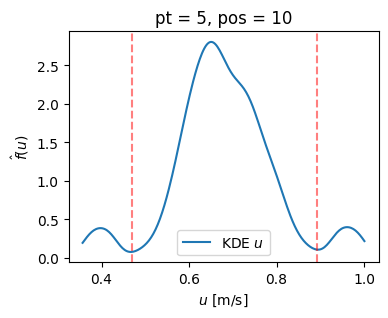

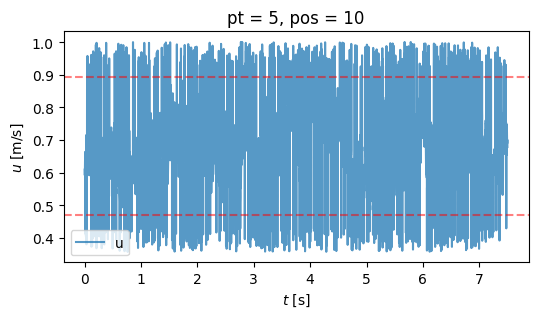

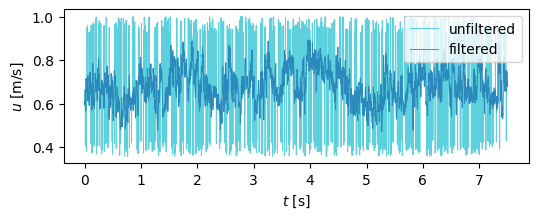

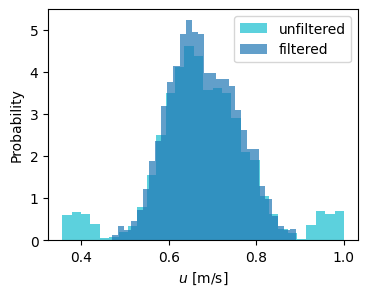

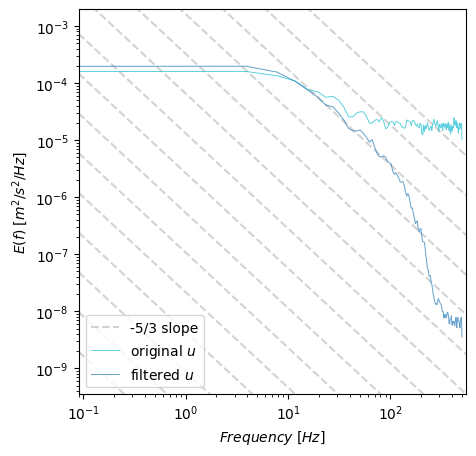

dataframe: 


,t,uvel,uvel_scaled,uvel_scaled_centered,uvel_spiked,uvel_filtered
0,0.000,0.609383,0.342900,-0.148440,-0.148440,0.609383
1,0.001,0.597374,0.317267,-0.174073,-0.174073,0.597374
2,0.002,0.592224,0.306276,-0.185064,-0.185064,0.592224
3,0.003,0.596632,0.315684,-0.175656,-0.175656,0.596632
4,0.004,0.611079,0.346519,-0.144820,-0.144820,0.611079


In [23]:
# Uses the UKDE despiking methods of Kraus 2024. 

##  --- User input ----------------------------- 
S_cut = 0.1 # gradient of the kernel where the cutoff is defined
R_cut = 0.1 # ratio of peak density to the density at S_cut

hu_METHOD = 'ROT_stdev' # options include:'IslamZhu','Chen_ures','ROT_stdev','ROT_Qn'
k_chen = 100 # coef if using the 'Chen_ures' hu_METHOD
ADV_FACE = 'singular and separate' # options are 'side' or 'down' for 4-beam Vectrino; 'singular and separate' when using despike_UKDE_1D

SHOW_PLOTS = 'yes' # to hide plots in notebook output use 'no'
SAVE_PLOTS = 'yes' # to not save the plots use 'no'
TITLE_PLOTS = 'yes' # to not title the plots use 'no'

plotpad = 0.05 # padding in output
plottitle = str('pt = '+str(i_point+1)+', pos = '+str(pos))
datapt = i_point+1

data = data_TowneBL2
vel_cname = 'uvel'
time_cname = 't'

##  -------------------------------------------


# produce a filtered or despiked dataframe, i.e. dataf (which is the same as data but filtered)
u_out, Id_li, ui = despike_UKDE_1D(data, fs, R_cut, S_cut, time_cname, vel_cname, 
                                   plotpad, plottitle, fig_folder, datapt, hu_METHOD, ADV_FACE,
                                   SHOW_PLOTS, SAVE_PLOTS, TITLE_PLOTS)

# save filtered ascii
dataf = pd.DataFrame({'t': t_arr_og, 'uvel': u_arr_og, 'uvel_scaled': u_arr_s, 'uvel_scaled_centered': u_arr_szc, 
                      'uvel_spiked': u_spiked_arr_szc, 'uvel_filtered': u_out})
# dataf = dataf.astype(float)
dataf.to_csv(velfilter_folder+'/ptNo'+str(datapt)+'_filtered.csv',index=False)

print('dataframe: ')
dataf.head(5)